In [1]:
import os
import warnings

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader

from train import create_net
from utils.eval import eval_net

warnings.filterwarnings("ignore")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
net = create_net(device, 1, 1, 'checkpoints/09-23_14:11:55/Net_best.pth')

[INFO]: **********************************************************************
Network: ResNet
	1 input channels
	1 output channels (classes)

[INFO]: Model loaded from checkpoints/09-23_14:11:55/Net_best.pth


In [4]:
transform = T.Compose([
    T.Resize(51), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(51), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
    #T.Normalize(mean=[.5], std=[.5]) # 标准化至[-1, 1]，规定均值和标准差
])

In [5]:
dataset = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/', transform=transform, loader=lambda path: Image.open(path))
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7888)
labels = [dataset[i][1] for i in range(len(dataset))]
train_idx, val_idx = list(ss.split(np.array(labels)[:,np.newaxis], labels))[0]
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, val_idx)
n_train = len(train)
n_val = len(val)
train_loader = DataLoader(train, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=512, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

[INFO]: 
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      2996
         1.0       0.92      0.91      0.92      3917

    accuracy                           0.90      6913
   macro avg       0.90      0.90      0.90      6913
weighted avg       0.91      0.90      0.91      6913



'checkpoints/09-23_14:11:55/PR-curve.png'

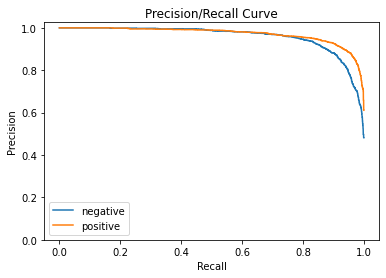

In [6]:
eval_net(net, val_loader, device, True, 'checkpoints/09-23_14:11:55/')

In [ ]:
img = Image.open('111.png')
img = transform(img).unsqueeze(0).to(device=device)
img.requires_grad_()
net.zero_grad()
pred_cate = net(img)
print(f'pred_cate:{pred_cate.item()}')
target = torch.tensor([[0]], dtype=torch.float32).to(device=device, dtype=torch.float32)
loss = F.binary_cross_entropy_with_logits(pred_cate, target)
print(f'loss:{loss.item()}')
loss.backward()
grad = img.grad.data.squeeze(0).permute(1, 2, 0).squeeze(2)

In [ ]:
img_grad = torch.abs(grad)
img_grad = (img_grad / img_grad.max() * 255).type(torch.uint8)
img_grad = Image.fromarray(img_grad.cpu().numpy())
display(img_grad)

In [ ]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/0/'
error_0_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() > 0:
            print(f)
            error_0_list.append(f)
            
print(f'len of error 0:{len(error_0_list)}')

In [ ]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/1/'
error_1_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() < 0:
            print(f)
            error_1_list.append(f)
            
print(f'len of error 1:{len(error_1_list)}')